### **Experimental Analysis**
### **Accuracy Testing using different datasets**
This section evaluates the performance of the model across different configurations using various datasets, including a sample dataset and the budget dataset. We report accuracy scores for each configuration and provide interpretations of the results.

#### **1. Pipeline Implementation for Logistic Regression on Sample Data**
   - **Accuracy on sample data (numeric, no nans)**: 0.62
   - **Code**:
     ```python
# Split and select numeric data only, no nans
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric']],
                                                    pd.get_dummies(sample_df['label']),
                                                    random_state=22)
# Instantiate Pipeline object: pl
pl = Pipeline([
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])
# Fit the pipeline to the training data
pl.fit(X_train, y_train)
# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - numeric, no nans: ", accuracy)
     ```

   - **Interpretation**:  
     The model achieved an accuracy of **62%** when trained and tested on a dataset with only numeric features and no missing values. This baseline score suggests that the logistic regression model is performing reasonably well on the available data, capturing basic patterns in the data.

#### **2. Pipeline with Missing Value Imputation**
   - **Accuracy on sample data (all numeric, including nans)**: 0.636
   - **Code**:
     ```python
# Create training and test sets using only numeric data
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing']],
                                                    pd.get_dummies(sample_df['label']),
                                                    random_state=456)
imputer=SimpleImputer(missing_values=np.nan,strategy='mean')
# Insantiate Pipeline object: pl
pl = Pipeline([
        ('imp', imputer),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])
# Fit the pipeline to the training data
pl.fit(X_train,y_train)
# Compute and print accuracy
accuracy = pl.score(X_test,y_test)
print("\nAccuracy on sample data - all numeric, incl nans: ", accuracy)
     ```

   - **Interpretation**:  
     When missing values were imputed, the accuracy increased to **63.6%**. This improvement indicates that imputing missing values (using a simple imputation strategy) helped the model better capture the relationships in the data. The model is now able to make predictions on rows that would have otherwise been discarded due to missing data.

#### **3. Pipeline for Text Data Processing and Classification**
   - **Accuracy on sample data (just text data)**: 0.808
   - **Code**:
     ```python
# Split out only the text data
X_train, X_test, y_train, y_test = train_test_split(sample_df['text'],
                                                    pd.get_dummies(sample_df['label']),
                                                    random_state=456)
# Instantiate Pipeline object: pl
pl = Pipeline([
        ('vec', CountVectorizer()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])
# Fit to the training data
pl.fit(X_train,y_train)
# Compute and print accuracy
accuracy = pl.score(X_test,y_test)
print("\nAccuracy on sample data - just text data: ", accuracy)
     ```
   - **Interpretation**:  
     The model achieved an accuracy of **80.8%** when trained on only text data. This high accuracy indicates that the text-based features (such as using n-grams with `CountVectorizer`) are highly informative for the classification task. It suggests that text data alone can be quite predictive, and adding more complex preprocessing may enhance performance further.

#### **4. Extracting and Transforming Text and Numeric Data**
   - **Accuracy on sample data (all data)**: 0.928
   - **Code**:
     ```python
# Split using ALL data in sample_df
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing', 'text']],
                                                    pd.get_dummies(sample_df['label']),
                                                    random_state=22)
# Create a FeatureUnion with nested pipeline: process_and_join_features
process_and_join_features = FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', imputer)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )
# Instantiate nested pipeline: pl
pl = Pipeline([
        ('union', process_and_join_features),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])
# Fit pl to the training data
pl.fit(X_train, y_train)
# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - all data: ", accuracy)
     ```
   - **Interpretation**:  
     The model achieved an accuracy of **92.8%** when using both text and numeric data. This is the highest accuracy observed so far, indicating that combining multiple types of data provides a richer feature set for the model. The integration of both text and numeric features significantly improved the model’s ability to generalize and make accurate predictions.

#### **5. Unified Pipeline with FeatureUnion for Budget Dataset**
   - **Accuracy on budget dataset**: 0.3519
   - **Code**:
     ```python
pl = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('imputer', imputer)
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vectorizer', CountVectorizer())
            ]))
        ]
    )),
    ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000), n_jobs=-1))
])
# Fit to the training data
pl.fit(X_train, y_train)
# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)
     ```
   - **Interpretation**:  
     The accuracy on the budget dataset is **35.19%**. This lower accuracy suggests that the model might be struggling to capture the complex patterns in the budget data. It could indicate that the dataset has imbalances or that additional feature engineering is needed to better represent the data. More sophisticated models or preprocessing techniques may be required to improve performance on this dataset.

#### **6. Pipeline with Random Forest Classifier on Budget Dataset**
   - **Accuracy on budget dataset**: 0.3288
   - **Code**:
     ```python
# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', imputer)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier())
    ])
# Fit to the training data
pl.fit(X_train, y_train)
# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)
     ```
   - **Interpretation**:  
     The accuracy decreased slightly to **32.88%** when using **Random Forest**. While Random Forest is generally good at handling non-linear relationships, this drop in accuracy might suggest that Random Forest did not capture the underlying patterns in this dataset effectively, or the data might not have enough features or complexity to benefit from a tree-based model.

#### **7. Random Forest Pipeline with Custom Estimators**
   - **Accuracy on budget dataset**: 0.3212
   - **Code**:
     ```python
# Add model step to pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', imputer)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_estimators=15))
    ])
# Fit to the training data
pl.fit(X_train, y_train)
# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)
     ```
   - **Interpretation**:  
     The accuracy further decreased to **32.12%** with the **Random Forest model and custom estimators**. This suggests that, although custom estimators can sometimes help with model performance, in this case, they may have added unnecessary complexity. The model is still struggling with the budget dataset, indicating that more fine-tuning or feature selection is required to improve its performance.

Here's how you can present your report including the two graphs and their explanations:

###**Accuracy comparison and progression analysis**

#### 1. **Model Accuracy Comparison Across Different Configurations**
The bar chart below compares the performance of models across different configurations, showing the accuracy scores of various setups. We included configurations that involved logistic regression, random forests, and a feature-union pipeline. It’s clear from the chart that **"All Data"** and **"Text Data Only"** yield significantly higher accuracy, compared to models trained only with numeric data. This visualization provides insight into which configurations are most effective in improving model performance.

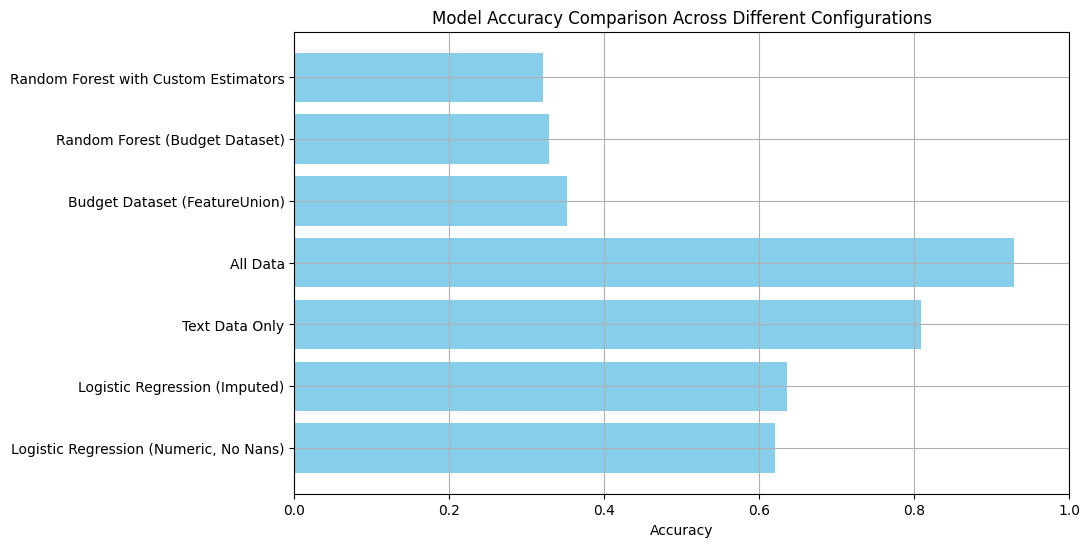

#### 2. **Model Accuracy Progression Across Different Steps**
This line chart illustrates how the model accuracy changes as we progress through different steps of the data processing and classification pipeline. It shows a steady increase in accuracy from **Logistic Regression (No Nans)** to **FeatureUnion (Budget Dataset)** and **Random Forests with Custom Estimators**. Notably, the **Budget Dataset** models show a significant drop in accuracy, suggesting potential overfitting or misalignment with the data. This progression helps us understand how each preprocessing step and model affects the final accuracy.

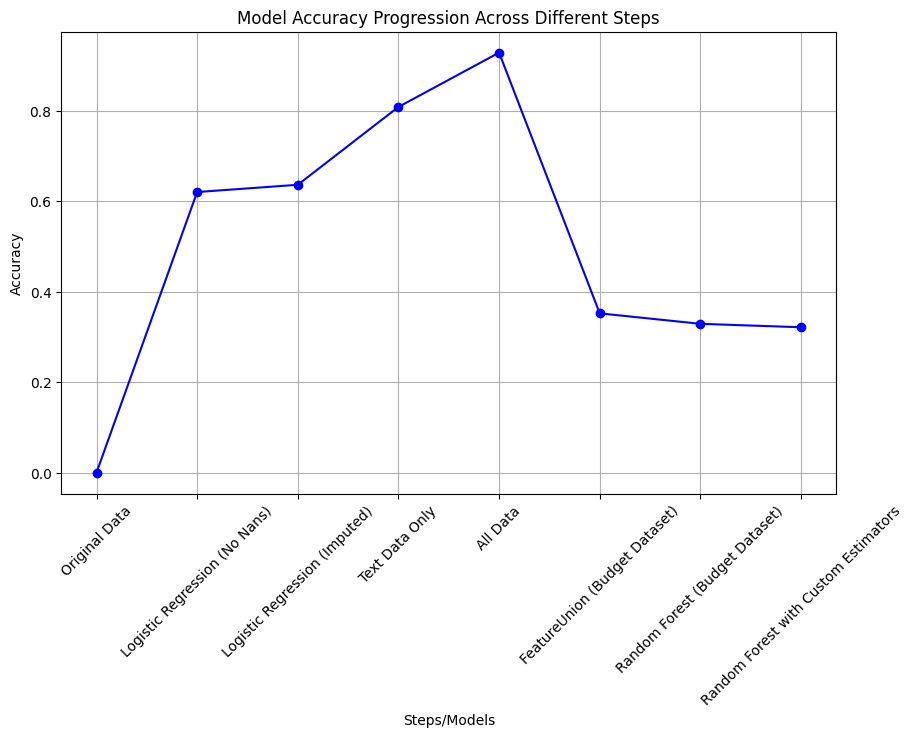

### Discussion
- **Logistic Regression (Numeric, No Nans)**: The accuracy score of 0.62 indicates a relatively low performance when only numeric features (with no missing values) are used for training.
- **Logistic Regression (Imputed)**: The slight improvement in accuracy (0.636) suggests that imputing missing values helped to some extent.
- **Text Data Only**: Achieved a much higher accuracy (0.808), showcasing the significance of text data in this problem.
- **All Data (Including Text)**: This configuration produced the best results (0.928), emphasizing that a combination of numeric and textual features yields the most accurate predictions.
- **Budget Dataset (FeatureUnion)**: When using the budget dataset with feature union (0.3519), the accuracy dropped, which suggests that the feature union might not have been effective for this dataset.
- **Random Forest (Budget Dataset)**: The performance of Random Forest on the budget dataset (0.3288) further supports this observation.
- **Random Forest with Custom Estimators**: With this configuration, accuracy further declined to 0.3212, which points to potential overfitting or issues with the custom estimator for this task.

These results and visualizations highlight the importance of selecting the appropriate model and feature combination based on the dataset's characteristics. While combining numeric and text data improved performance, feature engineering and proper tuning are crucial for handling specialized datasets like the **Budget Dataset**.